<font size = 6> <font color = white> **Trabalho Prático 1: Compressão de Imagens**



```
Diogo Tuler Chaves (2022043663)
João Marcos (2022043728)
```

### Imports


In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import numpy as np
import io
from scipy.fftpack import dct
from scipy import fftpack
from heapq import heappush, heappop, heapify
from collections import defaultdict
from skimage import data

### Métricas

In [3]:
# Entropia da imagem
def calcEntropy(img):
    hist, bins = np.histogram(img.ravel(), bins=np.arange(np.min(img), np.max(img) + 2))
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

In [4]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


### Abrindo a imagem e instalando no formato pgm

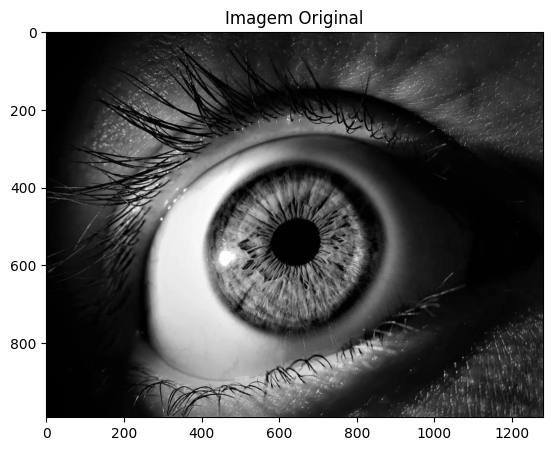



Entropia: 7.225
Tamanho: 1269760 bytes
8.000 bits/pixel




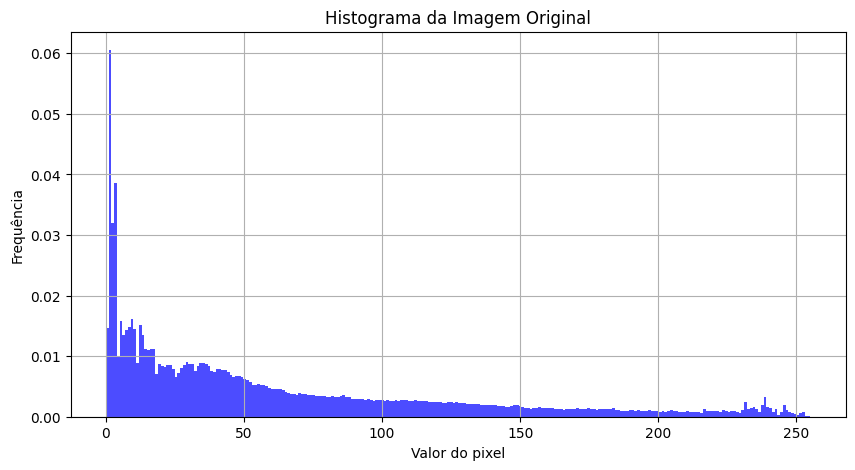

In [5]:
img = cv2.imread('olho.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
if ( (img.shape[0] % 8 != 0) or (img.shape[1] % 8 != 0) ):
  new_height = ((img.shape[0] + 7) // 8) * 8
  new_width = ((img.shape[1] + 7) // 8) * 8
  img = cv2.resize(img, (new_width, new_height))

cv2.imwrite('original_image.pgm', img)


plt.figure(figsize=(10, 5))
plt.title("Imagem Original")
plt.imshow(img, cmap='gray')

plt.show()

bits_p_item  = img.dtype.itemsize * 8
nbits = img.shape[0]*img.shape[1] * bits_p_item
print("\n\nEntropia: %5.3f" % calcEntropy(img))
print ("Tamanho: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel\n\n" % (nbits/img.size))


plt.figure(figsize=(10, 5))
plt.hist(img.flatten(), bins=256, density=True, color='b', alpha=0.7)
plt.xlabel('Valor do pixel')
plt.ylabel('Frequência')
plt.title('Histograma da Imagem Original')
plt.grid(True)
plt.show()

### DCT e IDCT

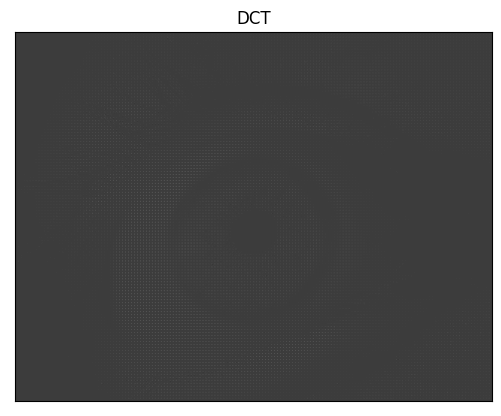



Entropia pós DCT: 3.294
Tamanho pós DCT: 10158080 bytes
64.000 bits/pixel pós DCT




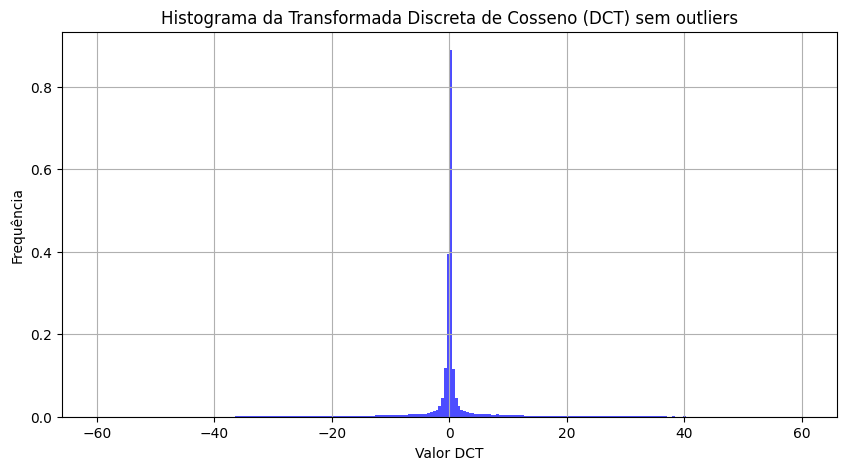

In [6]:
size = img.shape
IDCT = np.zeros(size, dtype=float)
DCT = np.zeros(size, dtype=float)


step = 8

# Divida a imagem em blocos de 8x8 e aplique a DCT a cada bloco
for y in range(0, size[0], step):
    for x in range(0, size[1], step):
        dct = get_2D_dct(img[y:y+step, x:x+step])
        idct = get_2d_idct(dct)
        IDCT[y:y+step, x:x+step] = idct
        DCT[y:y+step, x:x+step] = dct

plt.imshow(DCT, cmap='gray')
plt.title('DCT'), plt.xticks([]), plt.yticks([])
plt.show()

bits_p_item  = DCT.dtype.itemsize * 8
nbits = DCT.size * bits_p_item
print("\n\nEntropia pós DCT: %5.3f" % calcEntropy(DCT))
print ("Tamanho pós DCT: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel pós DCT\n\n" % (nbits/DCT.size))

plt.figure(figsize=(10, 5))
plt.hist(DCT.flatten(), bins=256, range=(-60,60), density=True, color='b', alpha=0.7)
plt.xlabel('Valor DCT')
plt.ylabel('Frequência')
plt.title('Histograma da Transformada Discreta de Cosseno (DCT) sem outliers')
plt.grid(True)
plt.show()


### DCT quantizada

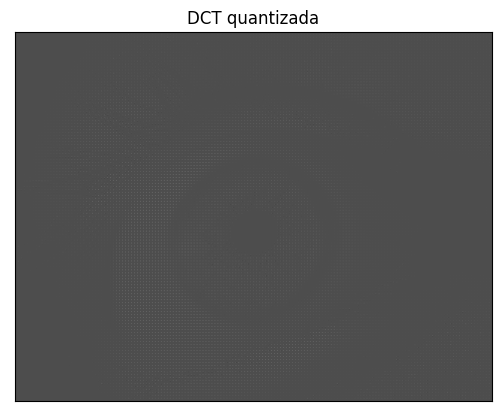



Entropia pós DCT quantizada: 0.947
Tamanho pós DCT quantizada: 10158080 bytes
64.000 bits/pixel pós DCT quantizada




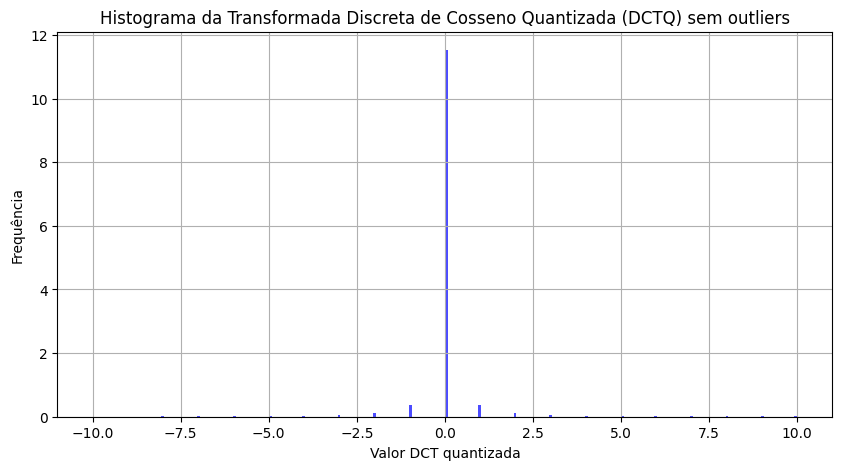

In [7]:
# aplicação da tabela de quantização
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
# quantization matrix
quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]], dtype=float)


DCTQ = np.zeros_like(img, dtype=float)
for y in range(0, size[0], step):
  for x in range(0, size[1], step):
    dct = get_2D_dct(img[y:y+step, x:x+step])
    dct = (np.divide(dct, quantization_matrix))
    dct = dct.round()
    DCTQ[y:y+step, x:x+step] = dct

plt.imshow(DCTQ, cmap='gray')
plt.title('DCT quantizada'), plt.xticks([]), plt.yticks([])
plt.show()

bits_p_item  = DCTQ.dtype.itemsize * 8
nbits = DCTQ.size * bits_p_item
print("\n\nEntropia pós DCT quantizada: %5.3f" % calcEntropy(DCTQ))
print ("Tamanho pós DCT quantizada: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel pós DCT quantizada\n\n" % (nbits/DCTQ.size))

plt.figure(figsize=(10, 5))
plt.hist(DCTQ.flatten(), bins=256, range=(-10,10), density=True, color='b', alpha=0.7)
plt.xlabel('Valor DCT quantizada')
plt.ylabel('Frequência')
plt.title('Histograma da Transformada Discreta de Cosseno Quantizada (DCTQ) sem outliers')
plt.grid(True)
plt.show()



### Preditiva

In [8]:
def zigzag_order(matrix):
    height, width = matrix.shape
    ordered_matrix = np.zeros((height, width), dtype=matrix.dtype)

    for i in range(height + width - 1):
        if i % 2 == 0:
            # Para cima (da esquerda para a direita)
            if i < height:
                start_row, start_col = i, 0
            else:
                start_row, start_col = height - 1, i - height + 1
            while start_row >= 0 and start_col < width:
                ordered_matrix[start_row, start_col] = matrix[start_row, start_col]
                start_row -= 1
                start_col += 1
        else:
            # Para baixo (da direita para a esquerda)
            if i < width:
                start_row, start_col = 0, i
            else:
                start_row, start_col = i - width + 1, width - 1
            while start_row < height and start_col >= 0:
                ordered_matrix[start_row, start_col] = matrix[start_row, start_col]
                start_row += 1
                start_col -= 1

    return ordered_matrix

zigzag = zigzag_order(DCTQ)

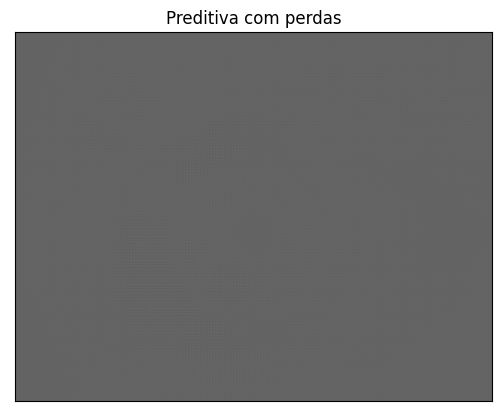



Entropia pós Preditiva: 0.876
Tamanho pós Preditiva: 5079040 bytes
32.000 bits/pixel pós Preditiva




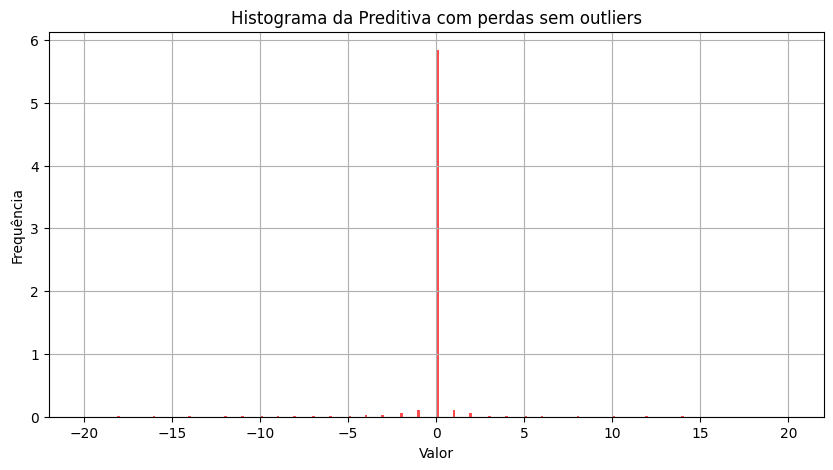

In [9]:
#Preditiva com perdas
def predictive_lossy_encode(matrix, quantization_step):
    height, width = matrix.shape
    encoded_matrix = np.zeros((height, width), dtype=np.int32)

    for y in range(height):
        for x in range(width):
            if x == 0 and y == 0:  # Não há valor anterior no canto superior esquerdo
                encoded_matrix[y, x] = matrix[y, x]
            elif x == 0:  # Não há valor anterior na primeira coluna, exceto no topo
                predicted_value = matrix[y - 1, x]
                actual_value = matrix[y, x]
                diff = actual_value - predicted_value
                quantized_diff = np.round(diff / quantization_step)
                encoded_matrix[y, x] = quantized_diff
            elif y == 0:  # Não há valor anterior na primeira linha, exceto na esquerda
                predicted_value = matrix[y, x - 1]
                actual_value = matrix[y, x]
                diff = actual_value - predicted_value
                quantized_diff = np.round(diff / quantization_step)
                encoded_matrix[y, x] = quantized_diff
            else:
                predicted_value = 0.5 * (matrix[y - 1, x] + matrix[y, x - 1])
                actual_value = matrix[y, x]
                diff = actual_value - predicted_value
                quantized_diff = np.round(diff / quantization_step)
                encoded_matrix[y, x] = quantized_diff

    return encoded_matrix

ZIG_ZAG = zigzag_order(DCTQ)

#Preditiva com perdas
predictive_lossy_encoded_dct = np.array(predictive_lossy_encode(ZIG_ZAG, 0.5
                                                               ))
plt.imshow(predictive_lossy_encoded_dct, cmap='gray')
plt.title('Preditiva com perdas'), plt.xticks([]), plt.yticks([])
plt.show()

bits_p_item  = predictive_lossy_encoded_dct.dtype.itemsize * 8
nbits = predictive_lossy_encoded_dct.size * bits_p_item
print("\n\nEntropia pós Preditiva: %5.3f" % calcEntropy(predictive_lossy_encoded_dct))
print ("Tamanho pós Preditiva: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel pós Preditiva\n\n" % (nbits/predictive_lossy_encoded_dct.size))

plt.figure(figsize=(10, 5))
plt.hist(predictive_lossy_encoded_dct.flatten(), bins=256, range=(-20,20), density=True, color='r', alpha=0.7)
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Histograma da Preditiva com perdas sem outliers')
plt.grid(True)
plt.show()

### HUFFMAN


#### Funções Auxiliares

In [10]:
def encodeHuffman(symb2freq):
    #Huffman transformando os valores em códigos
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

In [11]:
def encode(dict_huff,img):
  #De fato transformar os valores da matriz em códigos
    compressed_img = []

  #Adiciona os pixels
    for row in img:
        for pixel in row:
            pixel_key = int(pixel)
            compressed_img.append(dict_huff[pixel_key])

    return compressed_img

In [12]:
def int_to_32bits_string(n):
    if n < 0:
        n = (1 << 32) + n

    binary_str = format(n, '032b')
    return binary_str

def img2file(dict_huff,compressed_img,file,shape):
    curr_byte = 0
    bits_in_byte = 0

    for s in shape:
        for bit in int_to_32bits_string(s):
            curr_byte = (curr_byte << 1) | int(bit)
            bits_in_byte += 1

            if bits_in_byte == 8:
                file.write(bytes([curr_byte]))
                curr_byte = 0
                bits_in_byte = 0

    for bit in int_to_32bits_string(len(dict_huff)):
        curr_byte = (curr_byte << 1) | int(bit)
        bits_in_byte += 1

        if bits_in_byte == 8:
            file.write(bytes([curr_byte]))
            curr_byte = 0
            bits_in_byte = 0

    for key, code in dict_huff.items():

        for bit in int_to_32bits_string(key):
            curr_byte = (curr_byte << 1) | int(bit)
            bits_in_byte += 1

            if bits_in_byte == 8:
                file.write(bytes([curr_byte]))
                curr_byte = 0
                bits_in_byte = 0

        for bit in int_to_32bits_string(len(code)):
            curr_byte = (curr_byte << 1) | int(bit)
            bits_in_byte += 1

            if bits_in_byte == 8:
                file.write(bytes([curr_byte]))
                curr_byte = 0
                bits_in_byte = 0

        for bit in code:
            curr_byte = (curr_byte << 1) | int(bit)
            bits_in_byte += 1

            if bits_in_byte == 8:
                file.write(bytes([curr_byte]))
                curr_byte = 0
                bits_in_byte = 0

    for code in compressed_img:
        for bit in code:
                curr_byte = (curr_byte << 1) | int(bit)
                bits_in_byte += 1

                if bits_in_byte == 8:
                    file.write(bytes([curr_byte]))
                    curr_byte = 0
                    bits_in_byte = 0

    if bits_in_byte > 0:
        curr_byte <<= (8 - bits_in_byte)
        file.write(bytes([curr_byte]))



In [13]:
def file2img(file):
    binary_data = file.read()
    data = ''.join(format(byte, '08b') for byte in binary_data)
    data = io.StringIO(data)
    img_shape = []


    #Para recuperar o shape
    img_shape.append(int(data.read(32), 2))
    img_shape.append(int(data.read(32), 2))


    #Para recuperar o dicionário
    dict_huff_inv = {}
    dict_size = int(data.read(32), 2)
    for _ in range(dict_size):
        binary_str = data.read(32)
        if binary_str[0] == '1':
          inverted = ''.join('1' if bit == '0' else '0' for bit in binary_str)
          key = -int(inverted, 2) - 1
        else:
          key = int(binary_str, 2)
        code_length = int(data.read(32), 2)
        code = data.read(code_length)

        dict_huff_inv[code] = key

    #Para recuperar a img
    decompressed_img = []
    code = ""
    num_code = 0
    while True:
        bit = data.read(1)
        if not bit:
            break
        code = code + bit
        if code in dict_huff_inv:
            decompressed_img.append(dict_huff_inv[code])
            num_code += 1
            if num_code == img_shape[0]*img_shape[1]:
                break
            code = ""


    return img_shape,dict_huff_inv,decompressed_img


#### Compressão

In [14]:
def compression(file,img):
    print("Comprimindo a imagem...")

    hist_img, bins = np.histogram(img.ravel(), bins=np.arange(np.min(img), np.max(img) + 2))


    hist_img = hist_img.ravel()/hist_img.sum()

    symb2freq = defaultdict(float)

    aux = 0
    for i in range(int(np.min(img)), int(np.max(img)+1)):
        symb2freq[i] = hist_img[aux]
        aux += 1

    list_huff = encodeHuffman(symb2freq)
    dict_huff  = {}
    for value in list_huff:
        dict_huff[value[0]] = value[1]


    compressed_img = encode(dict_huff,img)
    img2file(dict_huff,compressed_img,file,img.shape)
    print("Imagem comprimida com sucesso!\n")

    nbits = 0
    for i in range(len(compressed_img)):
        nbits += len(compressed_img[i])

    return symb2freq,nbits,list_huff,compressed_img


In [15]:
with open("compressed_image.bin", "wb") as file:
    img2 = predictive_lossy_encoded_dct
    symb2freq,nbits,list_huff,compressed_img = compression(file,img2)
    file.close()

Comprimindo a imagem...
Imagem comprimida com sucesso!



#### Sumário da compressão

In [16]:
def dec_sumary(symb2freq,nbits,list_huff,img,compressed_img):

    entrop_img = calcEntropy(img)

    # bits por pixel
    bpp = nbits / (img.shape[0]*img.shape[1])

    print ("Sumário da compressão:")
    print ("Entropia da imagem original: %5.3f" % entrop_img)
    print ("Tamanho da imagem de saída: %d bytes" % (nbits / 8))
    print ("%5.3f bits/pixel na imagem de saída" % bpp)
    print ("Eficiência da códificação: %5.3f" % (entrop_img/bpp))
    print ("Taxa de compressão (sem o header): %5.3f" % (8/bpp))

    print ("\nHuffman\nValor\tProbabilidade\t\tCódigo gerado por Huffman")
    for p in list_huff:
        if (symb2freq[p[0]] > 0):
            print ("%d\t%f\t%s" % (p[0], symb2freq[p[0]], p[1]))
    print("\n\n\n")

    plt.imshow(img, cmap = 'gray')
    plt.title('Imagem original'), plt.xticks([]), plt.yticks([])
    plt.show()


Sumário da compressão:
Entropia da imagem original: 7.225
Tamanho da imagem de saída: 227011 bytes
1.430 bits/pixel na imagem de saída
Eficiência da códificação: 5.051
Taxa de compressão (sem o header): 5.593

Huffman
Valor	Probabilidade		Código gerado por Huffman
0	0.905509	1
-1	0.017774	000
-2	0.010133	0011
1	0.016045	0110
2	0.008295	01111
-6	0.002522	010000
-4	0.003999	011100
-3	0.003112	010100
4	0.002480	001011
-10	0.001110	0010001
-8	0.001648	0101011
-7	0.001216	0010100
-5	0.001852	0101110
3	0.002101	0111011
6	0.001307	0100011
-18	0.000563	00100101
-16	0.000659	01000101
-14	0.000810	01010101
-13	0.000529	00100000
-12	0.000942	01011110
-11	0.000685	01001000
-9	0.000769	01001110
5	0.000741	01001101
8	0.001019	01110101
10	0.000892	01011010
12	0.000736	01001011
14	0.000617	00101010
-30	0.000447	010110011
-28	0.000307	001001111
-26	0.000281	001001001
-24	0.000301	001001110
-22	0.000400	010101000
-20	0.000416	010110000
-19	0.000299	001001101
-17	0.000363	010010100
-15	0.000462	010110111

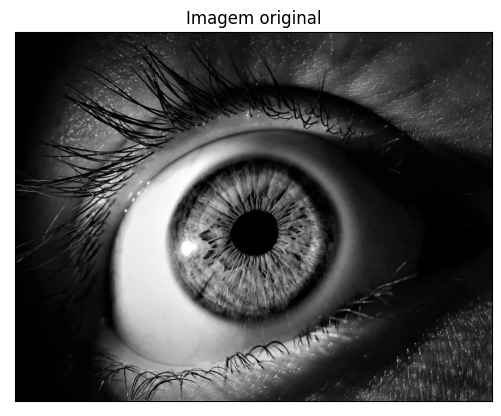

In [17]:
dec_sumary(symb2freq,nbits,list_huff,img,compressed_img)

#### Descompressão

In [18]:
def decompression(file):
    print("Descomprimindo a imagem...")
    img_shape,dict_huff_inv,decompressed_img = file2img(file)

    decompressed_img = np.array(decompressed_img)
    decompressed_img = decompressed_img.reshape(img_shape[0],img_shape[1])

    print("Imagem descomprimida com sucesso!\n")

    return decompressed_img

In [19]:
with open("compressed_image.bin", "rb") as file:
    decompressed_img = decompression(file)

Descomprimindo a imagem...
Imagem descomprimida com sucesso!



#### Sumário da descompressão

In [20]:

def dec_sumary(decompressed_img,img):

    if np.array_equal(img, decompressed_img):
        print("Imagens iguais!\n\n")
    else:
        print("Imagens diferentes!\n\n")

    plt.figure(figsize=(10,10))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Imagem comprimida'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(decompressed_img, cmap='gray')
    plt.title('Imagem descomprimida'), plt.xticks([]), plt.yticks([])
    plt.show()

Imagens iguais!




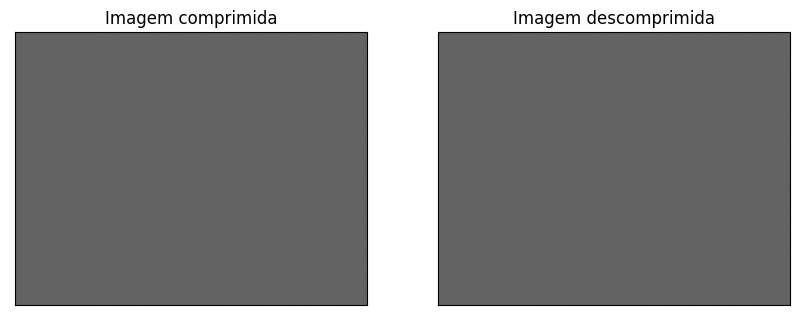

In [21]:
dec_sumary(decompressed_img,img2)

### Inverso das preditivas

In [22]:
def predictive_lossy_decode(encoded_matrix, quantization_step):
    height, width = encoded_matrix.shape
    decoded_matrix = np.zeros((height, width), dtype=int)

    for y in range(height):
        for x in range(width):
            if x == 0 and y == 0:  # Não há valor anterior no canto superior esquerdo
                decoded_matrix[y, x] = encoded_matrix[y, x]
            elif x == 0:  # Não há valor anterior na primeira coluna, exceto no topo
                predicted_value = decoded_matrix[y - 1, x]
                quantized_diff = encoded_matrix[y, x]
                diff = quantized_diff * quantization_step
                actual_value = predicted_value + diff
                decoded_matrix[y, x] = actual_value
            elif y == 0:  # Não há valor anterior na primeira linha, exceto na esquerda
                predicted_value = decoded_matrix[y, x - 1]
                quantized_diff = encoded_matrix[y, x]
                diff = quantized_diff * quantization_step
                actual_value = predicted_value + diff
                decoded_matrix[y, x] = actual_value
            else:
                predicted_value = 0.5 * (decoded_matrix[y - 1, x] + decoded_matrix[y, x - 1])
                quantized_diff = encoded_matrix[y, x]
                diff = quantized_diff * quantization_step
                actual_value = predicted_value + diff
                decoded_matrix[y, x] = actual_value

    return decoded_matrix

decompressed_pos_pred = predictive_lossy_decode(decompressed_img,0.5)

In [23]:
def reverse_zigzag_order(ordered_matrix):
    height, width = ordered_matrix.shape
    original_matrix = np.zeros((height, width), dtype=ordered_matrix.dtype)

    row, col = 0, 0
    for i in range(height + width - 1):
        if i % 2 == 0:
            # Para cima (da esquerda para a direita)
            if i < height:
                start_row, start_col = i, 0
            else:
                start_row, start_col = height - 1, i - height + 1
            while start_row >= 0 and start_col < width:
                original_matrix[start_row, start_col] = ordered_matrix[start_row, start_col]
                start_row -= 1
                start_col += 1
        else:
            # Para baixo (da direita para a esquerda)
            if i < width:
                start_row, start_col = 0, i
            else:
                start_row, start_col = i - width + 1, width - 1
            while start_row < height and start_col >= 0:
                original_matrix[start_row, start_col] = ordered_matrix[start_row, start_col]
                start_row += 1
                start_col -= 1

    return original_matrix


In [24]:
original_matrix = reverse_zigzag_order(decompressed_pos_pred)

### IDCT Quantizada

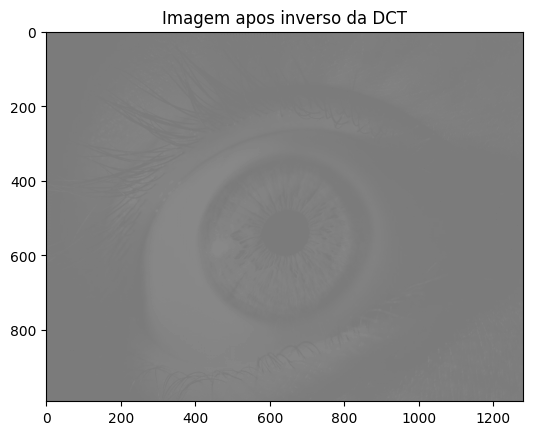

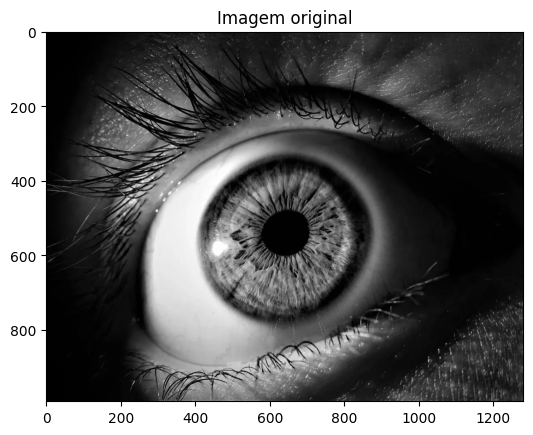



RMSE: 30.595
PSNR: 18.418




In [25]:
IDCTQ = np.zeros_like(DCTQ, dtype=float)
for y in range(0, size[0], step):
  for x in range(0, size[1], step):
    dct = original_matrix[y:y+step, x:x+step]
    idct = (np.multiply(dct, quantization_matrix))
    idct = get_2d_idct(idct)
    idct = idct.round()
    IDCTQ[y:y+step, x:x+step] = idct

plt.title("Imagem apos inverso da DCT")
plt.imshow(IDCTQ, cmap='gray')
plt.show()
cv2.imwrite('decompressed_image.pgm', img)

plt.title("Imagem original")
plt.imshow(img, cmap='gray')
plt.show()


print ("\n\nRMSE: %5.3f" % rmse(IDCTQ,img))
print ("PSNR: %5.3f\n\n" % psnr(IDCTQ,img))